In [5]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random

In [7]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
inputdir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
path_train = inputdir + '/train'
path_test = inputdir + '/test'
path_val = inputdir + '/val'
train_normal = os.path.join(path_train + '/NORMAL')
train_pneumonia = os.path.join(path_train + '/PNEUMONIA')
test_normal = os.path.join(path_test + '/NORMAL')
test_pneumonia = os.path.join(path_test + '/PNEUMONIA')
val_normal = os.path.join(path_val + '/NORMAL')
val_pneumonia = os.path.join(path_val + '/PNEUMONIA')
print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))
print("Total number of normal images in val set: ", len(os.listdir(val_normal)))
print("Total number of pnuemonic images in val set: ", len(os.listdir(val_pneumonia)))

Total number of normal images in training set:  1341
Total number of pneumonic images in training set:  3875
Total number of normal images in test set:  234
Total number of pneumonic images in test set:  390
Total number of normal images in val set:  8
Total number of pnuemonic images in val set:  8


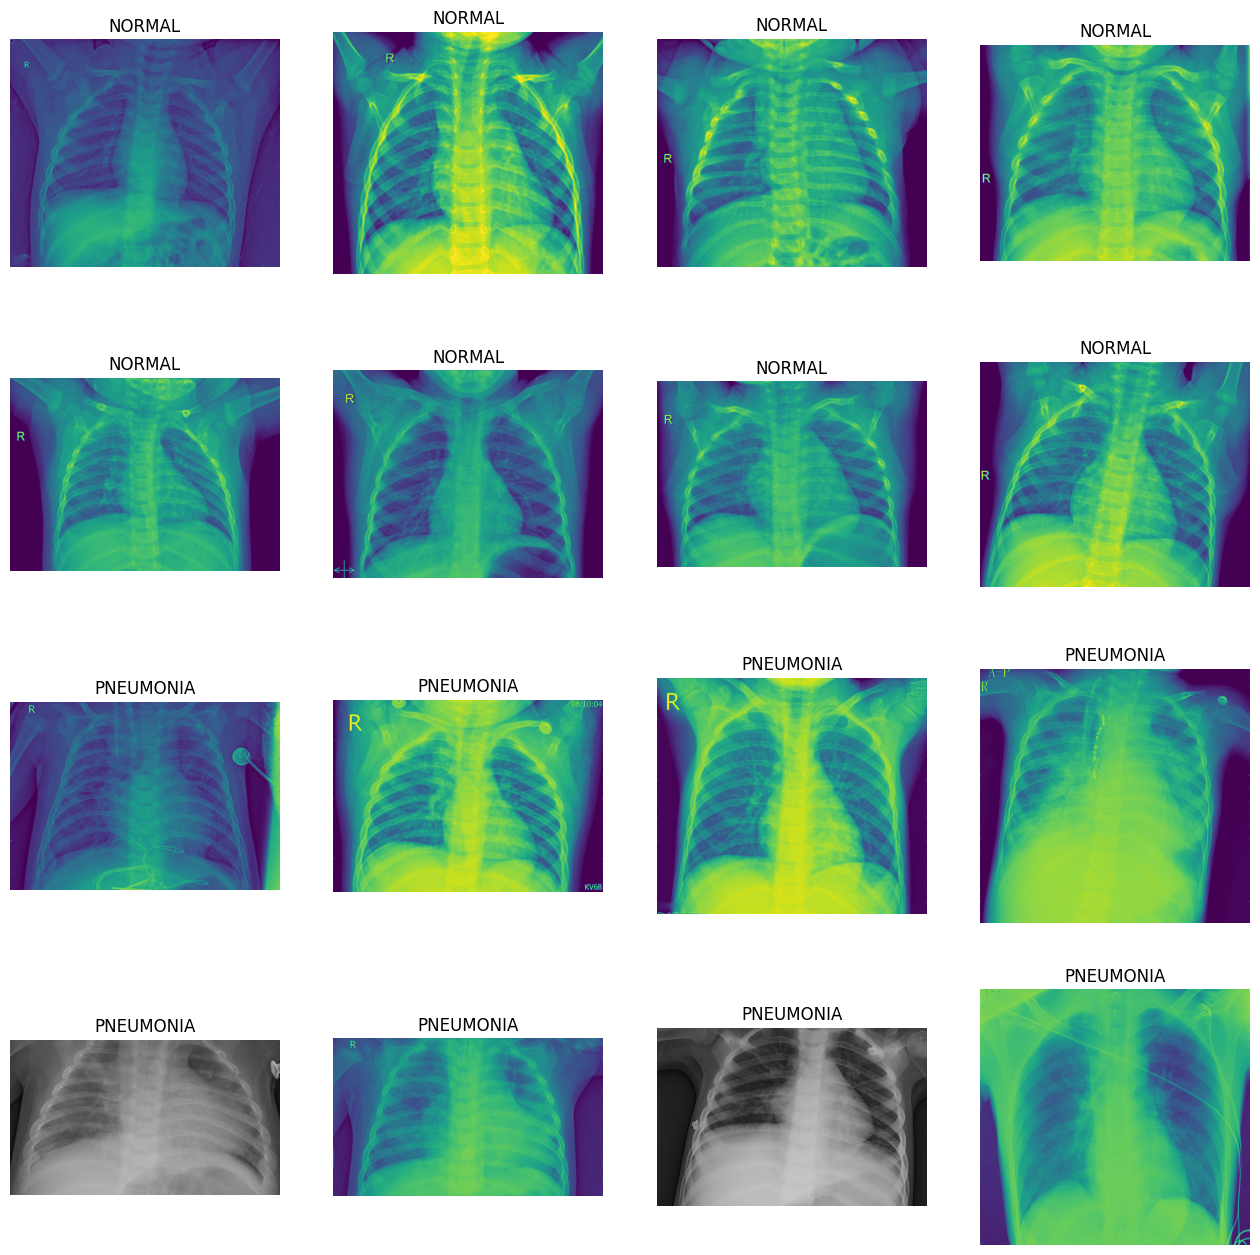

In [9]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
next_normal_pix = [os.path.join(train_normal, fname) for fname in os.listdir(train_normal)[0:8]]
next_pneumonia_pix = [os.path.join(train_pneumonia, fname) for fname in os.listdir(train_pneumonia)[0:8]]
for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    if i<=7 :
        sp.title.set_text('NORMAL')
    else :
        sp.title.set_text('PNEUMONIA')
    plt.imshow(img)
plt.show()

In [10]:
def data_processing(img_size, batch_size):
    
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       zoom_range = 0.3, 
                                       vertical_flip = True, 
                                       width_shift_range = 0.1, 
                                       height_shift_range = 0.1)
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_set = train_datagen.flow_from_directory(
        path_train, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    val_set = val_datagen.flow_from_directory(
        path_val, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_data = []
    test_labels = []
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path_test + cond)):
            img = plt.imread(path_test + cond + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, val_set, test_data, test_labels

In [11]:
img_size = 150
batch_size = 32
train_set, val_set, test_data, test_labels = data_processing(img_size, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = train_set.image_shape, activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))


model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

model.add(Dense(units = 1, activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-30 16:16:32.030974: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 75, 75, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 75, 75, 32)     │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 37, 37, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 37, 37, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 18, 18, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 18, 18, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 9, 9, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_7              │ (None, 9, 9, 256)      │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 2,314,337 (8.83 MB)

 Trainable params: 2,313,377 (8.82 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
checkpoint = ModelCheckpoint(filepath = 'trained_pneumonia_model.h5', save_best_only = True, save_weights_only = False)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2)

In [16]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))

weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

In [17]:
model_training = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=15,
    validation_data=val_set,
    callbacks=[checkpoint, lr_reduce],
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.6009 - loss: 0.6347 - val_accuracy: 0.5000 - val_loss: 0.8349 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 929ms/step - accuracy: 0.8348 - loss: 0.3656 - val_accuracy: 0.5000 - val_loss: 0.7669 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 922ms/step - accuracy: 0.8754 - loss: 0.2936 - val_accuracy: 0.5000 - val_loss: 1.3204 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.8737 - loss: 0.2843
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.8737 - loss: 0.2843 - val_accuracy: 0.5000 - val_loss: 2.6321 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 922ms/step - accuracy: 0.8886 - loss: 0.2693 - val_accuracy: 0.5000 - val_loss: 2.2639 - learning_rate: 3.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 928ms/step - accuracy

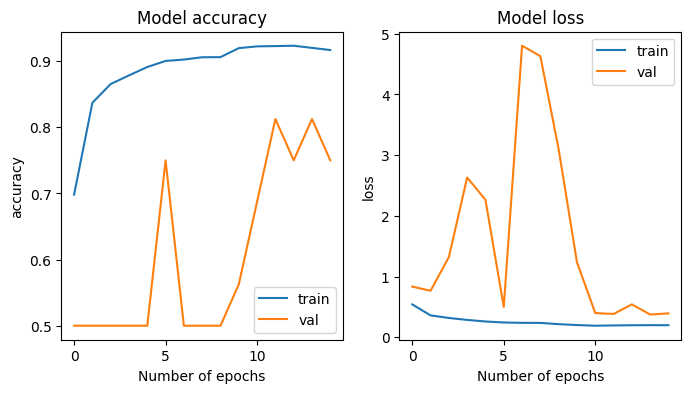

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_training.history[metric])
    ax[i].plot(model_training.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Number of epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step


Text(0.5, 1.0, 'Confusion Matrix')

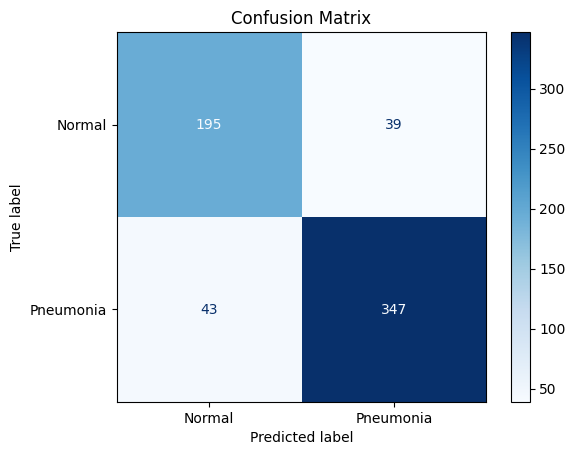

In [19]:
predictions = model.predict(test_data)
accuracy = accuracy_score(test_labels, np.round(predictions))*100
cm = confusion_matrix(test_labels, np.round(predictions))

cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

In [20]:
tn, fp, fn, tp = cm.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 86.85897435897436%
Precision: 89.89637305699482%
Recall: 88.97435897435896%
F1-score: 89.43298969072164


In [21]:
from sklearn.metrics import classification_report

predictions = np.round(model.predict(test_data))
print(classification_report(test_labels, predictions, target_names = ['Normal (Class 0)','Pnuemonia (Class 1)']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.82      0.83      0.83       234
Pnuemonia (Class 1)       0.90      0.89      0.89       390

           accuracy                           0.87       624
          macro avg       0.86      0.86      0.86       624
       weighted avg       0.87      0.87      0.87       624

